correct code

for 10 label

In [357]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = sorted(os.listdir(directory))  # Each person_name folder is a class label
    label_map = {label: idx for idx, label in enumerate(class_labels)}
    
    for person_name in class_labels:
        person_path = os.path.join(directory, person_name)
        if os.path.isdir(person_path):
            for hand in ['left', 'right']:
                hand_path = os.path.join(person_path, hand)
                if os.path.isdir(hand_path):
                    for finger in ['middle', 'ring', 'index']:
                        finger_path = os.path.join(hand_path, finger)
                        if os.path.isdir(finger_path):
                            for filename in os.listdir(finger_path):
                                if filename.endswith('.bmp'):
                                    img_path = os.path.join(finger_path, filename)
                                    try:
                                        # img = load_img(img_path, target_size=target_size)  # Load image
                                        img = cv2.imread(img_path) 
                                        img = cv2.resize(img, (224,224)) 
                                        # _,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
                                        img_array = img_to_array(img) / 255.0  # Normalize image
                                        images.append(img_array)
                                        labels.append(label_map[person_name])
                                    except Exception as e:
                                        print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Example usage
directory = "E:\Machine Learning Project\Finger Vein Database"  # Update with the actual path
X, y = load_images_from_directory(directory)

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("Dataset loaded successfully!")
# print("Train set size:", X_train.shape)
# print("Test set size:", X_test.shape)


<>:39: SyntaxWarning: invalid escape sequence '\M'
<>:39: SyntaxWarning: invalid escape sequence '\M'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20800\2126083148.py:39: SyntaxWarning: invalid escape sequence '\M'
  directory = "E:\Machine Learning Project\Finger Vein Database"  # Update with the actual path


In [358]:
X.shape

(360, 224, 224, 3)

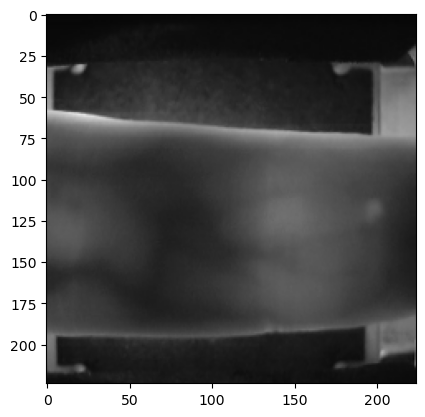

In [359]:
plt.imshow(X[200])

In [360]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [364]:
print("Dataset loaded successfully!")
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Dataset loaded successfully!
Train set size: (288, 224, 224, 3)
Test set size: (72, 224, 224, 3)


In [367]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import numpy as np
from skimage.color import rgb2gray  # To convert RGB to grayscale

def extract_features(images):
    features = []
    
    for img in images:
        # Convert RGB image to grayscale
        img_gray = rgb2gray(img)  # Converts to 2D grayscale image
        
        # Convert to float32 and normalize to [0, 1]
        img_gray = img_gray.astype(np.float32)  # No need to normalize again if using rgb2gray
        
        # Compute HOG features
        try:
            hog_features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        except Exception as e:
            print(f"HOG feature extraction failed for image {img.shape}: {e}")
            hog_features = np.zeros(0)  # Placeholder for failed extraction
        
        # Compute LBP features
        lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)  # Normalize histogram
        
        # Compute Gabor features
        try:
            gabor_real, gabor_imag = gabor(img_gray, frequency=0.6)
            gabor_features = [np.mean(gabor_real), np.var(gabor_real), np.mean(gabor_imag), np.var(gabor_imag)]
        except Exception as e:
            print(f"Gabor feature extraction failed for image {img.shape}: {e}")
            gabor_features = [0, 0, 0, 0]  # Placeholder for failed extraction
        
        # Concatenate all features
        feature_vector = np.hstack([hog_features, lbp_hist, gabor_features])
        features.append(feature_vector)
    
    return np.array(features)

# Extract features from X_train
X_train_features = extract_features(X_train)

print("Feature extraction completed!")
print("Feature shape:", X_train_features.shape)


Feature extraction completed!
Feature shape: (288, 26258)


In [368]:
num_classes = len(np.unique(y_train))  # Get the number of unique classes in the labels
num_classes

10

For 10 file

In [370]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define CNN Model
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(64, activation='relu'))  # Another fully connected layer
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare the labels (make sure they are one-hot encoded)
y_train = to_categorical(y_train, num_classes=num_classes)  # Assuming you have 'y_train' labels available

# Build the model
model = build_model(input_shape=(X_train_features.shape[1],), num_classes=10)  # Assuming 10 classes in classification

# Train the model
model.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_train_features, y_train)
print(f"Model Loss: {loss}, Model Accuracy: {accuracy}")


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.1176 - loss: 3.4048 - val_accuracy: 0.1034 - val_loss: 2.1668
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.1381 - loss: 2.4738 - val_accuracy: 0.3103 - val_loss: 1.9605
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.2691 - loss: 2.0541 - val_accuracy: 0.3103 - val_loss: 1.8888
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.2593 - loss: 1.9841 - val_accuracy: 0.4138 - val_loss: 1.8559
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.3012 - loss: 1.8720 - val_accuracy: 0.3793 - val_loss: 1.8037
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.2887 - loss: 1.8710 - val_accuracy: 0.3793 - val_loss: 1.7992
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3324 - loss: 1.8308 - val_accuracy: 0.5172 - val_loss: 1.7606
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.2886 - loss: 1.7938 - val_accuracy: 0.4655 - val_loss: 

for 33 label

In [418]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = sorted(os.listdir(directory))  # Each person_name folder is a class label
    label_map = {label: idx for idx, label in enumerate(class_labels)}
    
    for person_name in class_labels:
        person_path = os.path.join(directory, person_name)
        if os.path.isdir(person_path):
            for hand in ['left', 'right']:
                hand_path = os.path.join(person_path, hand)
                if os.path.isdir(hand_path):
                    for finger in ['middle', 'ring', 'index']:
                        finger_path = os.path.join(hand_path, finger)
                        if os.path.isdir(finger_path):
                            for filename in os.listdir(finger_path):
                                if filename.endswith('.bmp'):
                                    img_path = os.path.join(finger_path, filename)
                                    try:
                                        # img = load_img(img_path, target_size=target_size)  # Load image
                                        img = cv2.imread(img_path) 
                                        img = cv2.resize(img, (224,224)) 
                                        # _,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
                                        img_array = img_to_array(img) / 255.0  # Normalize image
                                        images.append(img_array)
                                        labels.append(label_map[person_name])
                                    except Exception as e:
                                        print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Example usage
directory = r"E:\Machine Learning Project\fingerten\Finger Vein Database"  # Update with the actual path
X, y = load_images_from_directory(directory)

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("Dataset loaded successfully!")
# print("Train set size:", X_train.shape)
# print("Test set size:", X_test.shape)


In [419]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [420]:
print("Dataset loaded successfully!")
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Dataset loaded successfully!
Train set size: (936, 224, 224, 3)
Test set size: (234, 224, 224, 3)


In [424]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import numpy as np
from skimage.color import rgb2gray  # To convert RGB to grayscale

def extract_features(images):
    features = []
    
    for img in images:
        # Convert RGB image to grayscale
        img_gray = rgb2gray(img)  # Converts to 2D grayscale image
        
        # Convert to float32 and normalize to [0, 1]
        img_gray = img_gray.astype(np.float32)  # No need to normalize again if using rgb2gray
        
        # Compute HOG features
        try:
            hog_features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        except Exception as e:
            print(f"HOG feature extraction failed for image {img.shape}: {e}")
            hog_features = np.zeros(0)  # Placeholder for failed extraction
        
        # Compute LBP features
        lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)  # Normalize histogram
        
        # Compute Gabor features
        try:
            gabor_real, gabor_imag = gabor(img_gray, frequency=0.6)
            gabor_features = [np.mean(gabor_real), np.var(gabor_real), np.mean(gabor_imag), np.var(gabor_imag)]
        except Exception as e:
            print(f"Gabor feature extraction failed for image {img.shape}: {e}")
            gabor_features = [0, 0, 0, 0]  # Placeholder for failed extraction
        
        # Concatenate all features
        feature_vector = np.hstack([hog_features, lbp_hist, gabor_features])
        features.append(feature_vector)
    
    return np.array(features)

# Extract features from X_train
X_train_features = extract_features(X_train)

print("Feature extraction completed!")
print("Feature shape:", X_train_features.shape)


Feature extraction completed!
Feature shape: (936, 26258)


In [388]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_features = scaler.fit_transform(X_train_features)


In [392]:
num_classes = len(y_train)  # Get the number of unique classes in the labels
num_classes

936

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define CNN Model
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(512, input_dim=input_shape[0], activation='relu'))  # Increase the number of neurons
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare the labels (make sure they are one-hot encoded)
num_classes = 33   # Update this value to match the number of classes in your dataset
y_train = to_categorical(y_train, num_classes=num_classes)  # Assuming you have 'y_train' labels available

# Build the model
model = build_model(input_shape=(X_train_features.shape[1],), num_classes=num_classes)  # Update num_classes here

# Train the model
model.fit(X_train_features, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_train_features, y_train)
print(f"Model Loss: {loss}, Model Accuracy: {accuracy}")


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.0476 - loss: 5.1884 - val_accuracy: 0.0319 - val_loss: 3.4002
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.0221 - loss: 3.6230 - val_accuracy: 0.1330 - val_loss: 3.3967
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.0668 - loss: 3.4197 - val_accuracy: 0.1330 - val_loss: 3.3507
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.0443 - loss: 3.4028 - val_accuracy: 0.1223 - val_loss: 3.2856
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.0831 - loss: 3.3323 - val_accuracy: 0.0904 - val_loss: 3.2116
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.0897 - loss: 3.2487 - val_accuracy: 0.1011 - val_loss: 3.1516
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.0829 - loss: 3.1943 - val_accuracy: 0.0904 - val_loss: 3.0757
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.1101 - loss: 3.0651 - val_accuracy: 0.

for 47 file

In [262]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define CNN Model
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(64, activation='relu'))  # Another fully connected layer
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare the labels (make sure they are one-hot encoded)
num_classes = 47  # Update this value to match the number of classes in your dataset
y_train = to_categorical(y_train, num_classes=num_classes)  # Assuming you have 'y_train' labels available

# Build the model
model = build_model(input_shape=(X_train_features.shape[1],), num_classes=num_classes)  # Update num_classes here

# Train the model
model.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_train_features, y_train)
print(f"Model Loss: {loss}, Model Accuracy: {accuracy}")


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.0235 - loss: 4.4170 - val_accuracy: 0.0443 - val_loss: 3.8373
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.0300 - loss: 3.8384 - val_accuracy: 0.0258 - val_loss: 3.8243
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.0367 - loss: 3.8250 - val_accuracy: 0.0148 - val_loss: 3.8355
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.0277 - loss: 3.8158 - val_accuracy: 0.0185 - val_loss: 3.7844
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.0269 - loss: 3.8129 - val_accuracy: 0.0443 - val_loss: 3.7553
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.0425 - loss: 3.7643 - val_accuracy: 0.0554 - val_loss: 3.7282
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.0355 - loss: 3.7843 - val_accuracy: 0.0590 - val_loss: 3.6946
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.0432 - loss: 3.7236 - val_accuracy: 0.0554 - v

In [264]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage.color import rgb2gray  # To convert RGB to grayscale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load images and labels
def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = sorted(os.listdir(directory))  # Each person_name folder is a class label
    label_map = {label: idx for idx, label in enumerate(class_labels)}
    
    for person_name in class_labels:
        person_path = os.path.join(directory, person_name)
        if os.path.isdir(person_path):
            for hand in ['left', 'right']:
                hand_path = os.path.join(person_path, hand)
                if os.path.isdir(hand_path):
                    for finger in ['middle', 'ring', 'index']:
                        finger_path = os.path.join(hand_path, finger)
                        if os.path.isdir(finger_path):
                            for filename in os.listdir(finger_path):
                                if filename.endswith('.bmp'):
                                    img_path = os.path.join(finger_path, filename)
                                    try:
                                        img = cv2.imread(img_path) 
                                        img = cv2.resize(img, (224,224)) 
                                        img_array = img_to_array(img) / 255.0  # Normalize image
                                        images.append(img_array)
                                        labels.append(label_map[person_name])
                                    except Exception as e:
                                        print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Extract features from the images
def extract_features(images):
    features = []
    
    for img in images:
        # Convert RGB image to grayscale
        img_gray = rgb2gray(img)  # Converts to 2D grayscale image
        
        # Convert to float32 and normalize to [0, 1]
        img_gray = img_gray.astype(np.float32)  # No need to normalize again if using rgb2gray
        
        # Compute HOG features
        try:
            hog_features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        except Exception as e:
            print(f"HOG feature extraction failed for image {img.shape}: {e}")
            hog_features = np.zeros(0)  # Placeholder for failed extraction
        
        # Compute LBP features
        lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)  # Normalize histogram
        
        # Compute Gabor features
        try:
            gabor_real, gabor_imag = gabor(img_gray, frequency=0.6)
            gabor_features = [np.mean(gabor_real), np.var(gabor_real), np.mean(gabor_imag), np.var(gabor_imag)]
        except Exception as e:
            print(f"Gabor feature extraction failed for image {img.shape}: {e}")
            gabor_features = [0, 0, 0, 0]  # Placeholder for failed extraction
        
        # Concatenate all features
        feature_vector = np.hstack([hog_features, lbp_hist, gabor_features])
        features.append(feature_vector)
    
    return np.array(features)

# Define the model
def build_improved_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(256, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
def augment_data(X_train_features, y_train):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Fit the data generator on X_train
    datagen.fit(X_train_features)
    return datagen

# Main function to run the code
def main():
    # Load the dataset
    directory = "E:/Machine Learning Project/Finger Vein Database"  # Update with the actual path
    X, y = load_images_from_directory(directory)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Extract features from training and test sets
    X_train_features = extract_features(X_train)
    X_test_features = extract_features(X_test)

    # Define the number of classes
    num_classes = len(np.unique(y_train))  # Get the number of unique classes

    # One-hot encode the labels
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    # Standardize the features
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    X_test_features = scaler.transform(X_test_features)

    # Build the model
    model = build_improved_model(input_shape=(X_train_features.shape[1],), num_classes=num_classes)

    # Data Augmentation
    datagen = augment_data(X_train_features, y_train)

    # Train the model using data augmentation
    history = model.fit(datagen.flow(X_train_features, y_train, batch_size=32),
                        epochs=20,
                        validation_data=(X_test_features, y_test))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_features, y_test)
    print(f"Model Loss: {loss}, Model Accuracy: {accuracy}")

    # Plot learning curves
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.0217 - loss: 14.0292 - val_accuracy: 0.0944 - val_loss: 3.7759
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.0338 - loss: 9.7336 - val_accuracy: 0.0914 - val_loss: 3.6499
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.0457 - loss: 6.7164 - val_accuracy: 0.0737 - val_loss: 3.7566
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.0296 - loss: 5.4719 - val_accuracy: 0.0236 - val_loss: 3.8074
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.0244 - loss: 4.8288 - val_accuracy: 0.0295 - val_loss: 3.8479
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.0344 - loss: 4.3828 - val_accuracy: 0.0324 - val_loss: 3.8508
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.0440 - loss: 4.1998 - val_accuracy: 0.0236 - val_loss: 3.8547
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.0326 - loss: 3.9991 - val_accuracy: 

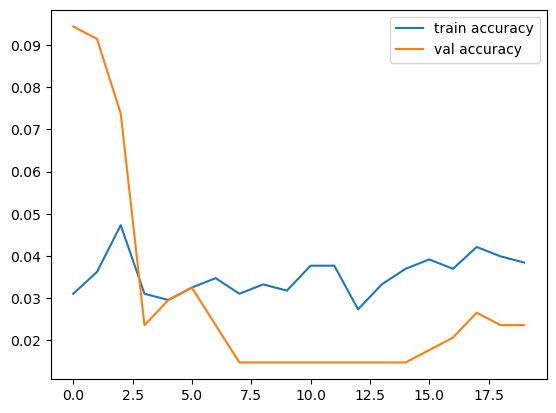

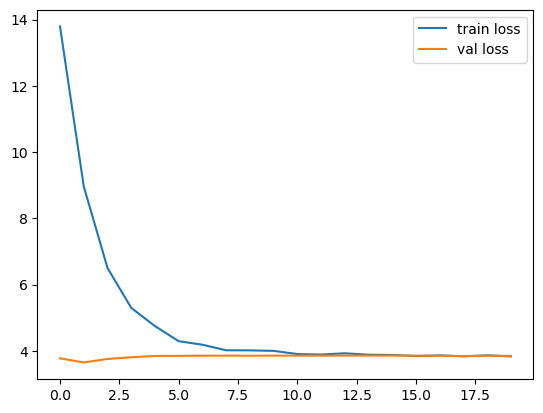

In [266]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage.color import rgb2gray
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load images and labels
def load_images_from_directory(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = sorted(os.listdir(directory))  # Each person_name folder is a class label
    label_map = {label: idx for idx, label in enumerate(class_labels)}
    
    for person_name in class_labels:
        person_path = os.path.join(directory, person_name)
        if os.path.isdir(person_path):
            for hand in ['left', 'right']:
                hand_path = os.path.join(person_path, hand)
                if os.path.isdir(hand_path):
                    for finger in ['middle', 'ring', 'index']:
                        finger_path = os.path.join(hand_path, finger)
                        if os.path.isdir(finger_path):
                            for filename in os.listdir(finger_path):
                                if filename.endswith('.bmp'):
                                    img_path = os.path.join(finger_path, filename)
                                    try:
                                        img = cv2.imread(img_path) 
                                        img = cv2.resize(img, (224,224)) 
                                        img_array = img_to_array(img) / 255.0  # Normalize image
                                        images.append(img_array)
                                        labels.append(label_map[person_name])
                                    except Exception as e:
                                        print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Extract features from the images
def extract_features(images):
    features = []
    
    for img in images:
        # Convert RGB image to grayscale
        img_gray = rgb2gray(img)  # Converts to 2D grayscale image
        
        # Convert to float32 and normalize to [0, 1]
        img_gray = img_gray.astype(np.float32)
        
        # Compute HOG features
        try:
            hog_features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        except Exception as e:
            print(f"HOG feature extraction failed for image {img.shape}: {e}")
            hog_features = np.zeros(0)  # Placeholder for failed extraction
        
        # Compute LBP features
        lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)  # Normalize histogram
        
        # Compute Gabor features
        try:
            gabor_real, gabor_imag = gabor(img_gray, frequency=0.6)
            gabor_features = [np.mean(gabor_real), np.var(gabor_real), np.mean(gabor_imag), np.var(gabor_imag)]
        except Exception as e:
            print(f"Gabor feature extraction failed for image {img.shape}: {e}")
            gabor_features = [0, 0, 0, 0]  # Placeholder for failed extraction
        
        # Concatenate all features
        feature_vector = np.hstack([hog_features, lbp_hist, gabor_features])
        features.append(feature_vector)
    
    return np.array(features)

# Define the model for 2D feature vector
def build_model_for_features(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(256, input_dim=input_shape[0], activation='relu'))  # Input dimension matches the number of features
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main function to run the code
def main():
    # Load the dataset
    directory = "E:/Machine Learning Project/Finger Vein Database"  # Update with the actual path
    X, y = load_images_from_directory(directory)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Extract features from training and test sets
    X_train_features = extract_features(X_train)
    X_test_features = extract_features(X_test)

    # Define the number of classes
    num_classes = len(np.unique(y_train))  # Get the number of unique classes

    # One-hot encode the labels
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    # Standardize the features
    scaler = StandardScaler()
    X_train_features = scaler.fit_transform(X_train_features)
    X_test_features = scaler.transform(X_test_features)

    # Build the model
    model = build_model_for_features(input_shape=(X_train_features.shape[1],), num_classes=num_classes)

    # Train the model
    history = model.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_data=(X_test_features, y_test))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_features, y_test)
    print(f"Model Loss: {loss}, Model Accuracy: {accuracy}")

    # Plot learning curves
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
